# MLP
Like MLP_207 with K=5 and epochs=200.

Use GMM for threshold.

In [13]:
from datetime import datetime
print(datetime.now())

2023-03-29 22:52:32.732231


In [14]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [15]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = set([0,2,3,4,5,6,7,8,9,10,11,12,13,14,15])   # only H1.hESC
FILTER_TAILS_TRAIN  = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TRAIN = False
FILTER_MIDDLE_TEST  = False
FILTER_NONE         = True

Python 3.9.16
sklearn 1.2.2


In [16]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.all_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.all_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [17]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [18]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [19]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-29 22:52:34.016681
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 64)                65664     
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [21]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [22]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_NONE or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_NONE or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-29 22:52:34.157246
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 3774
Num RCI: 3774
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.all_lncRNA_transcripts.csv
Loaded 16957 sequences.
2023-03-29 22:53:27.325989

Training # 1 1
2023-03-29 22:53:27.326814
2023-03-29 22:53:27.326876
Discriminator ZERO -1
Train 1:0 9728:3973 71.00%
Computed class weights: {0: 1.7242637805185, 1: 0.7042043585526315}
Valid 1:0 2307:949 70.85%
FIT
2023-03-29 22:53:27.495926


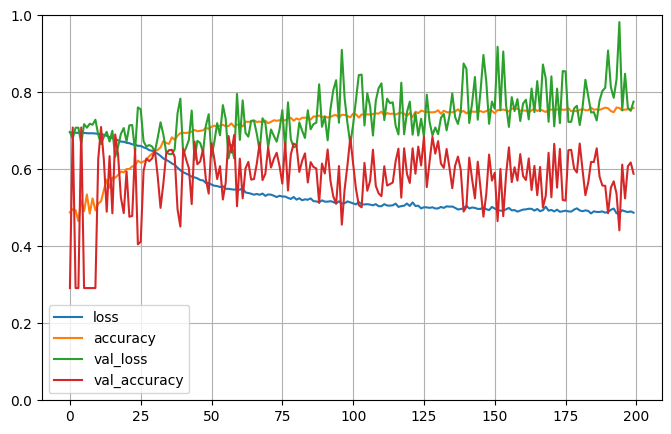


2023-03-29 22:57:50.640718

Testing # 1 1
2023-03-29 22:57:50.642668
2023-03-29 22:57:50.642713
PREDICT
2023-03-29 22:57:50.662153
Test 1:0 2307:949 70.85%
Predict 1:0 1943:1313 59.67%
Test sizes (3256, 1025) (3256,)
Range of scores: 0.00084581546 to 0.9998896
Score threshold 0.5
Confusion matrix
 [[ 461  488]
 [ 852 1455]]
Normalized matrix
 [[0.14158477 0.14987715]
 [0.26167076 0.44686732]]


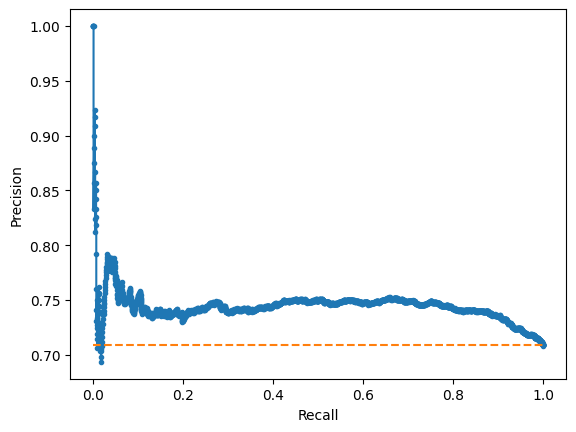

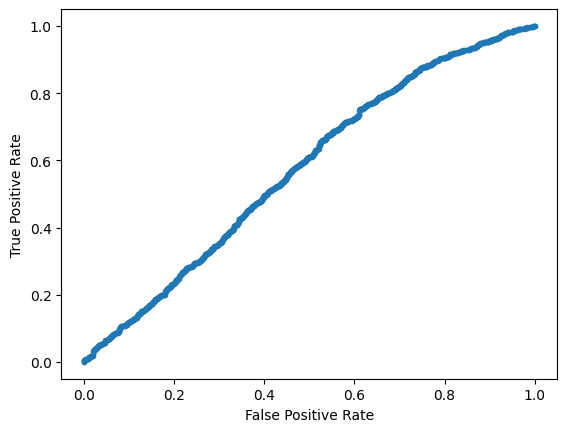

Accuracy: 58.85% Precision: 74.88% Recall: 63.07%
F1: 68.47% MCC: 0.1079
AUPRC: 74.45% AUROC: 57.45%
 accuracy [58.84520884520884]
 precision [74.88419969119917]
 recall [63.06892067620286]
 F1 [68.4705882352941]
 MCC [0.1078893922568159]
 AUPRC [74.44860894112352]
 AUROC [57.447371197660665]
2023-03-29 22:57:51.271113

Training # 1 2
2023-03-29 22:57:51.272490
2023-03-29 22:57:51.272556
Discriminator ZERO -1
Train 1:0 9553:4005 70.46%
Computed class weights: {0: 1.6926342072409488, 1: 0.7096200146550822}
Valid 1:0 2482:917 73.02%
FIT
2023-03-29 22:57:51.376231


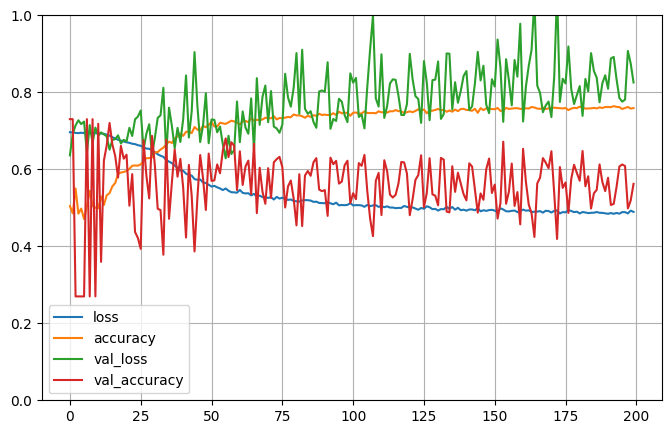


2023-03-29 23:02:14.321249

Testing # 1 2
2023-03-29 23:02:14.323696
2023-03-29 23:02:14.324060
PREDICT
2023-03-29 23:02:14.343566
Test 1:0 2482:917 73.02%
Predict 1:0 1932:1467 56.84%
Test sizes (3399, 1025) (3399,)
Range of scores: 0.0007591662 to 0.9999992
Score threshold 0.5
Confusion matrix
 [[ 448  469]
 [1019 1463]]
Normalized matrix
 [[0.13180347 0.13798176]
 [0.29979406 0.43042071]]


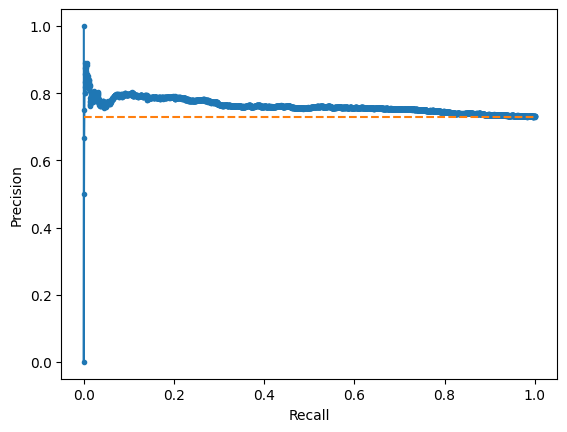

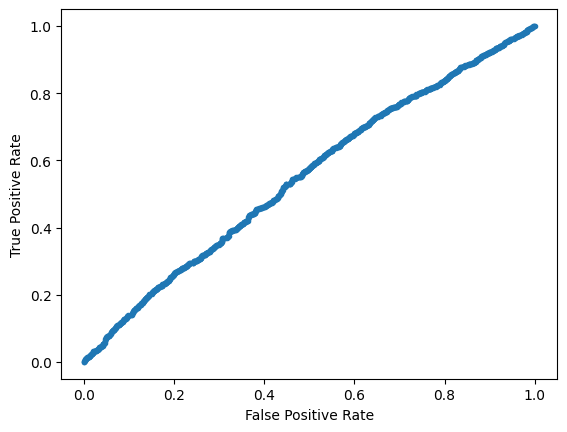

Accuracy: 56.22% Precision: 75.72% Recall: 58.94%
F1: 66.29% MCC: 0.0699
AUPRC: 76.12% AUROC: 55.06%
 accuracy [56.22241835834069]
 precision [75.72463768115942]
 recall [58.94439967767929]
 F1 [66.28908019936567]
 MCC [0.06989176199644129]
 AUPRC [76.11561837849987]
 AUROC [55.06249137739378]
2023-03-29 23:02:15.123019

Training # 1 3
2023-03-29 23:02:15.124019
2023-03-29 23:02:15.124267
Discriminator ZERO -1
Train 1:0 9876:4065 70.84%
Computed class weights: {0: 1.714760147601476, 1: 0.7058019441069259}
Valid 1:0 2159:857 71.58%
FIT
2023-03-29 23:02:15.243909


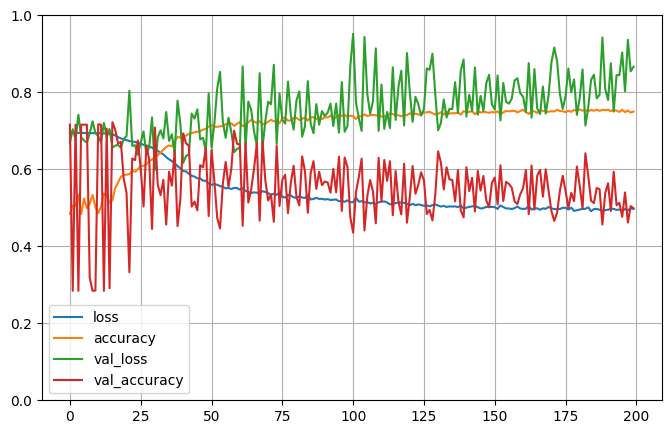


2023-03-29 23:06:38.696490

Testing # 1 3
2023-03-29 23:06:38.698877
2023-03-29 23:06:38.699259
PREDICT
2023-03-29 23:06:38.716245
Test 1:0 2159:857 71.58%
Predict 1:0 1295:1721 42.94%
Test sizes (3016, 1025) (3016,)
Range of scores: 0.0018527887 to 0.9980245
Score threshold 0.5
Confusion matrix
 [[ 533  324]
 [1188  971]]
Normalized matrix
 [[0.17672414 0.10742706]
 [0.3938992  0.3219496 ]]


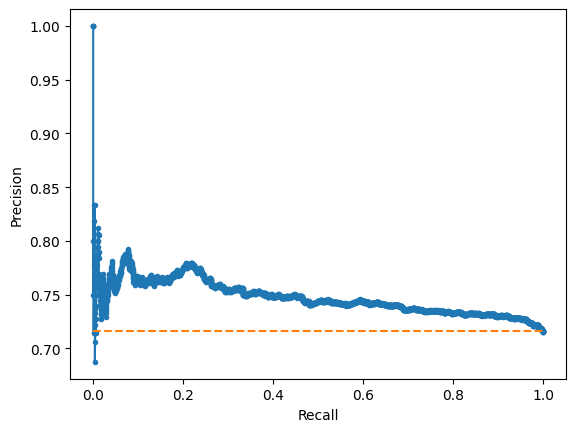

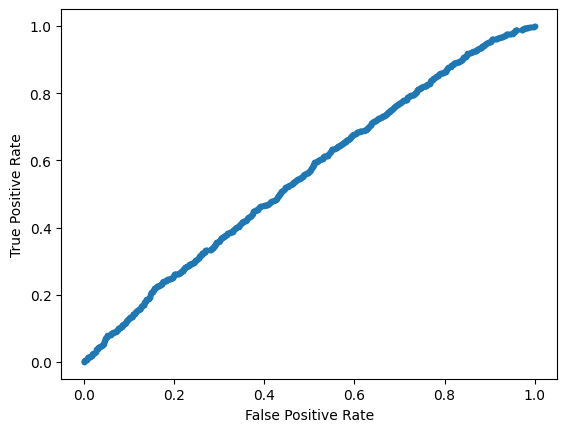

Accuracy: 49.87% Precision: 74.98% Recall: 44.97%
F1: 56.22% MCC: 0.0653
AUPRC: 74.76% AUROC: 55.55%
 accuracy [49.86737400530504]
 precision [74.98069498069498]
 recall [44.97452524316813]
 F1 [56.22466705269253]
 MCC [0.06531350531905496]
 AUPRC [74.75983093330206]
 AUROC [55.54945432081817]
2023-03-29 23:06:39.332403

Training # 1 4
2023-03-29 23:06:39.333925
2023-03-29 23:06:39.334017
Discriminator ZERO -1
Train 1:0 9772:3951 71.21%
Computed class weights: {0: 1.7366489496330042, 1: 0.7021592304543594}
Valid 1:0 2263:971 69.98%
FIT
2023-03-29 23:06:39.452623


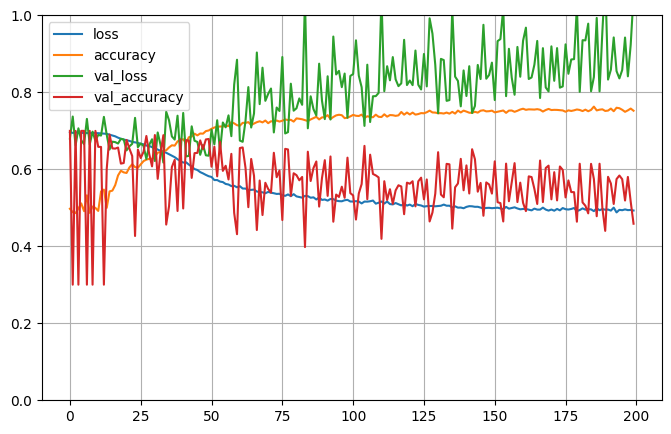


2023-03-29 23:11:02.802076

Testing # 1 4
2023-03-29 23:11:02.806215
2023-03-29 23:11:02.806483
PREDICT
2023-03-29 23:11:02.826904
Test 1:0 2263:971 69.98%
Predict 1:0 930:2304 28.76%
Test sizes (3234, 1025) (3234,)
Range of scores: 0.0003049393 to 0.99999726
Score threshold 0.5
Confusion matrix
 [[ 762  209]
 [1542  721]]
Normalized matrix
 [[0.23562152 0.06462585]
 [0.47680891 0.22294372]]


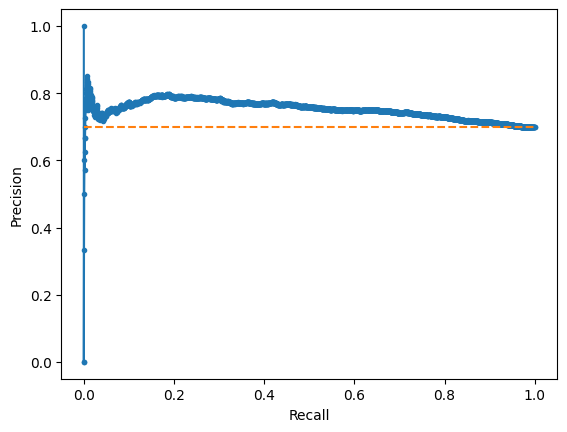

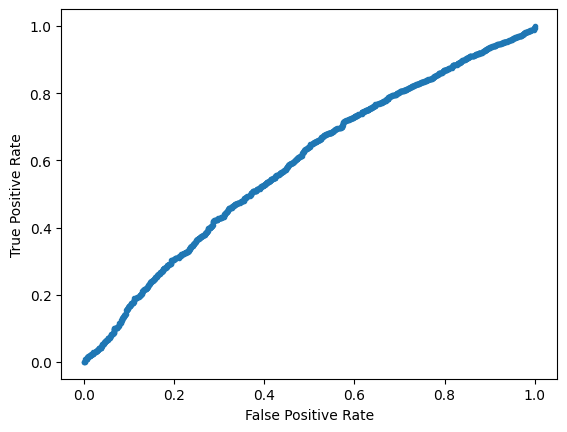

Accuracy: 45.86% Precision: 77.53% Recall: 31.86%
F1: 45.16% MCC: 0.1047
AUPRC: 75.14% AUROC: 58.78%
 accuracy [45.856524427953]
 precision [77.52688172043011]
 recall [31.86036235086169]
 F1 [45.16129032258065]
 MCC [0.10467149438407877]
 AUPRC [75.1360357489182]
 AUROC [58.78487630456913]
2023-03-29 23:11:03.580312

Training # 1 5
2023-03-29 23:11:03.581182
2023-03-29 23:11:03.581248
Discriminator ZERO -1
Train 1:0 9211:3694 71.38%
Computed class weights: {0: 1.7467514889009204, 1: 0.7005211160568885}
Valid 1:0 2824:1228 69.69%
FIT
2023-03-29 23:11:03.700523


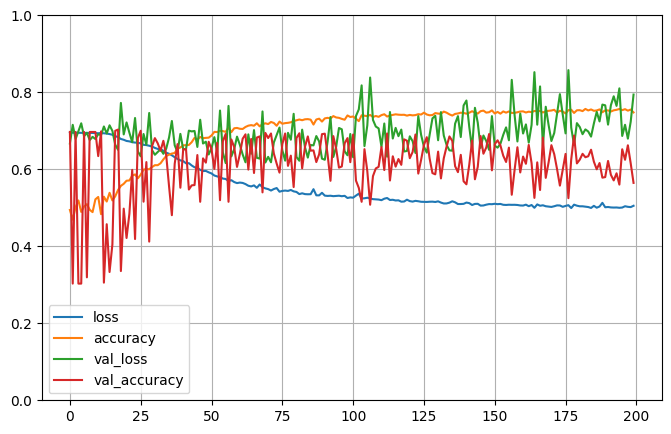


2023-03-29 23:15:26.861784

Testing # 1 5
2023-03-29 23:15:26.863202
2023-03-29 23:15:26.863241
PREDICT
2023-03-29 23:15:26.902219
Test 1:0 2824:1228 69.69%
Predict 1:0 1976:2076 48.77%
Test sizes (4052, 1025) (4052,)
Range of scores: 0.00055087777 to 0.9992548
Score threshold 0.5
Confusion matrix
 [[ 770  458]
 [1306 1518]]
Normalized matrix
 [[0.19002962 0.1130306 ]
 [0.32230997 0.37462981]]


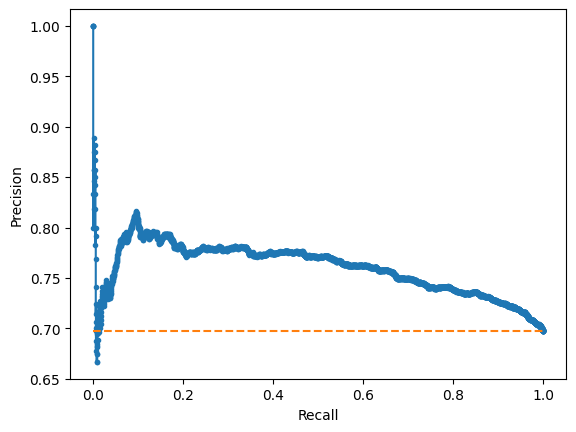

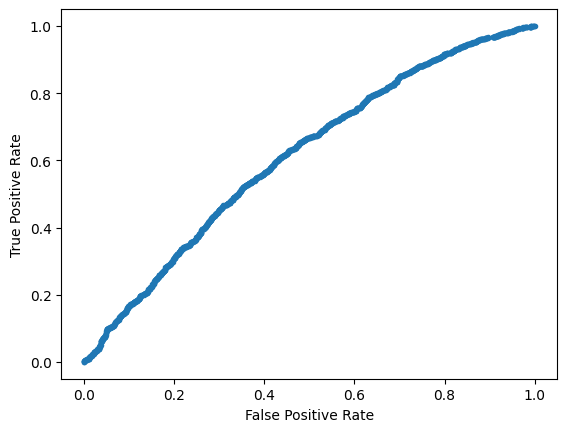

Accuracy: 56.47% Precision: 76.82% Recall: 53.75%
F1: 63.25% MCC: 0.1513
AUPRC: 76.02% AUROC: 61.27%
 accuracy [56.4659427443238]
 precision [76.82186234817814]
 recall [53.75354107648725]
 F1 [63.25000000000001]
 MCC [0.15131372751853756]
 AUPRC [76.01925230630616]
 AUROC [61.26610209373355]
2023-03-29 23:15:27.697334

Training # 2 1
2023-03-29 23:15:27.698162
2023-03-29 23:15:27.698229
Discriminator ZERO -1
Train 1:0 9308:3763 71.21%
Computed class weights: {0: 1.736779165559394, 1: 0.7021379458530297}
Valid 1:0 2727:1159 70.17%
FIT
2023-03-29 23:15:27.810265


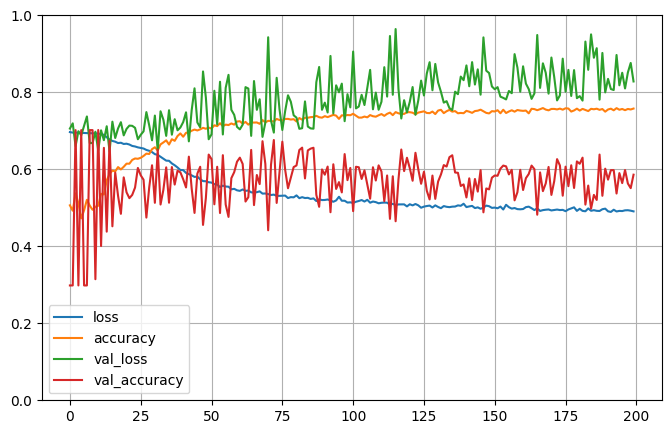


2023-03-29 23:19:09.633341

Testing # 2 1
2023-03-29 23:19:09.634536
2023-03-29 23:19:09.634817
PREDICT
2023-03-29 23:19:09.667303
Test 1:0 2727:1159 70.17%
Predict 1:0 2408:1478 61.97%
Test sizes (3886, 1025) (3886,)
Range of scores: 0.00015280287 to 0.99999934
Score threshold 0.5
Confusion matrix
 [[ 514  645]
 [ 964 1763]]
Normalized matrix
 [[0.13226969 0.16598044]
 [0.24806999 0.45367988]]


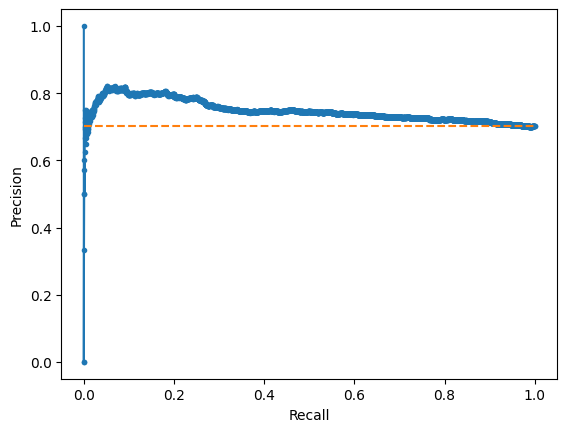

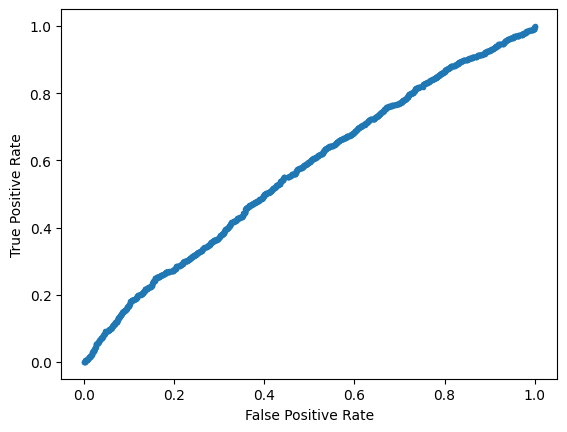

Accuracy: 58.59% Precision: 73.21% Recall: 64.65%
F1: 68.67% MCC: 0.0848
AUPRC: 74.73% AUROC: 56.78%
 accuracy [58.59495625321668]
 precision [73.21428571428571]
 recall [64.64979831316465]
 F1 [68.66601752677703]
 MCC [0.0847974711625064]
 AUPRC [74.72513120480804]
 AUROC [56.77516845731165]
2023-03-29 23:19:10.559070

Training # 2 2
2023-03-29 23:19:10.559332
2023-03-29 23:19:10.561515
Discriminator ZERO -1
Train 1:0 9683:4029 70.62%
Computed class weights: {0: 1.701662943658476, 1: 0.7080450273675514}
Valid 1:0 2352:893 72.48%
FIT
2023-03-29 23:19:10.778281


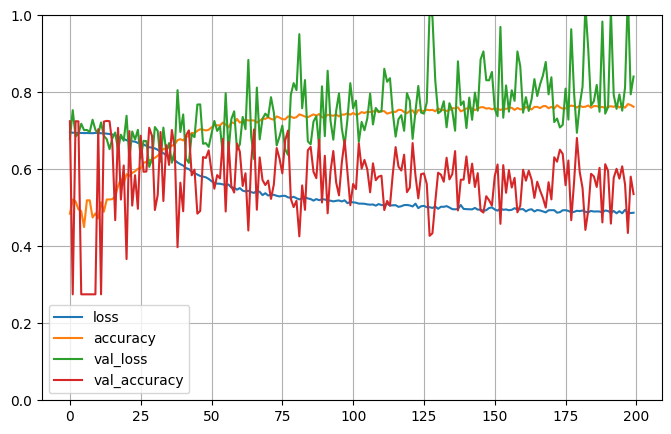


2023-03-29 23:23:34.133058

Testing # 2 2
2023-03-29 23:23:34.133158
2023-03-29 23:23:34.133200
PREDICT
2023-03-29 23:23:34.155656
Test 1:0 2352:893 72.48%
Predict 1:0 1653:1592 50.94%
Test sizes (3245, 1025) (3245,)
Range of scores: 0.00014185243 to 0.99849355
Score threshold 0.5
Confusion matrix
 [[ 489  404]
 [1103 1249]]
Normalized matrix
 [[0.15069337 0.12449923]
 [0.33990755 0.38489985]]


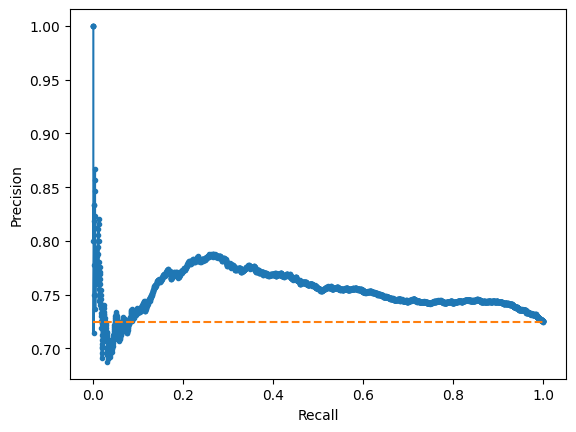

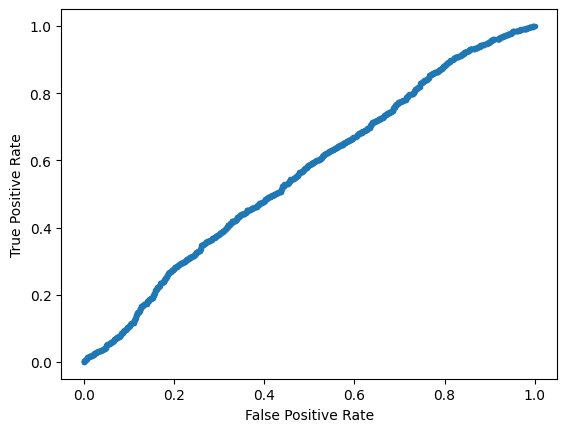

Accuracy: 53.56% Precision: 75.56% Recall: 53.10%
F1: 62.37% MCC: 0.0702
AUPRC: 75.40% AUROC: 56.10%
 accuracy [53.559322033898304]
 precision [75.55958862673926]
 recall [53.103741496598644]
 F1 [62.372034956304624]
 MCC [0.07024632387204909]
 AUPRC [75.39898720827563]
 AUROC [56.103856716258726]
2023-03-29 23:23:34.833845

Training # 2 3
2023-03-29 23:23:34.835505
2023-03-29 23:23:34.835566
Discriminator ZERO -1
Train 1:0 9720:3753 72.14%
Computed class weights: {0: 1.7949640287769784, 1: 0.6930555555555555}
Valid 1:0 2315:1169 66.45%
FIT
2023-03-29 23:23:34.955120


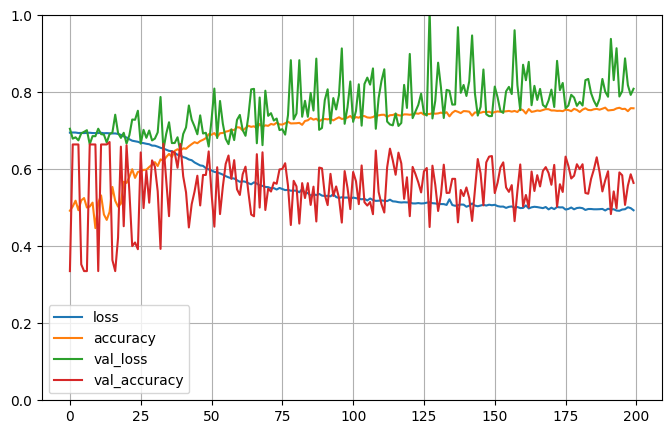


2023-03-29 23:27:58.201973

Testing # 2 3
2023-03-29 23:27:58.203327
2023-03-29 23:27:58.203695
PREDICT
2023-03-29 23:27:58.229659
Test 1:0 2315:1169 66.45%
Predict 1:0 2022:1462 58.04%
Test sizes (3484, 1025) (3484,)
Range of scores: 0.0007139906 to 0.9996456
Score threshold 0.5
Confusion matrix
 [[ 557  612]
 [ 905 1410]]
Normalized matrix
 [[0.15987371 0.17566016]
 [0.2597589  0.40470723]]


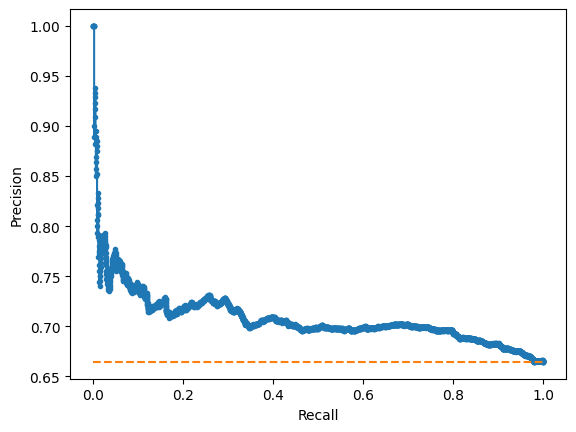

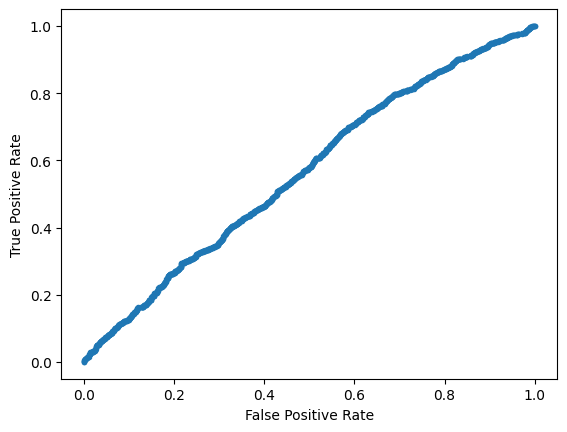

Accuracy: 56.46% Precision: 69.73% Recall: 60.91%
F1: 65.02% MCC: 0.0819
AUPRC: 70.82% AUROC: 56.42%
 accuracy [56.45809414466131]
 precision [69.73293768545994]
 recall [60.90712742980562]
 F1 [65.02190454231035]
 MCC [0.08185076442883345]
 AUPRC [70.82185077169228]
 AUROC [56.417273444471746]
2023-03-29 23:27:59.055339

Training # 2 4
2023-03-29 23:27:59.056592
2023-03-29 23:27:59.056810
Discriminator ZERO -1
Train 1:0 9847:4085 70.68%
Computed class weights: {0: 1.7052631578947368, 1: 0.7074235807860262}
Valid 1:0 2188:837 72.33%
FIT
2023-03-29 23:27:59.193918


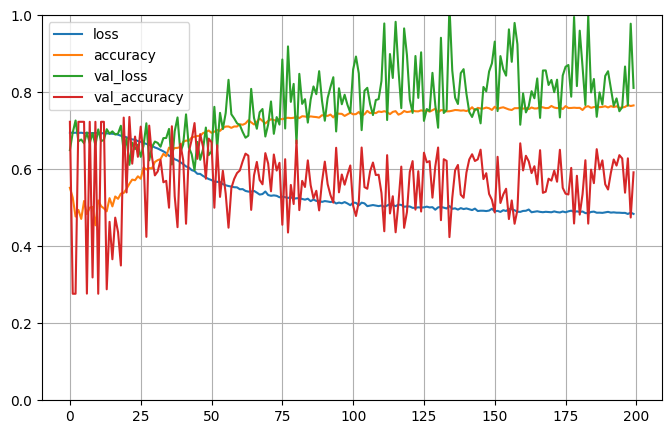


2023-03-29 23:32:23.183325

Testing # 2 4
2023-03-29 23:32:23.183440
2023-03-29 23:32:23.183484
PREDICT
2023-03-29 23:32:23.205838
Test 1:0 2188:837 72.33%
Predict 1:0 1786:1239 59.04%
Test sizes (3025, 1025) (3025,)
Range of scores: 0.0014911777 to 0.9998741
Score threshold 0.5
Confusion matrix
 [[ 421  416]
 [ 818 1370]]
Normalized matrix
 [[0.13917355 0.13752066]
 [0.27041322 0.45289256]]


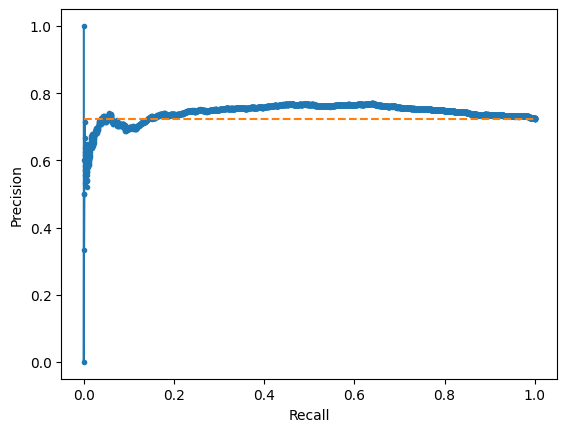

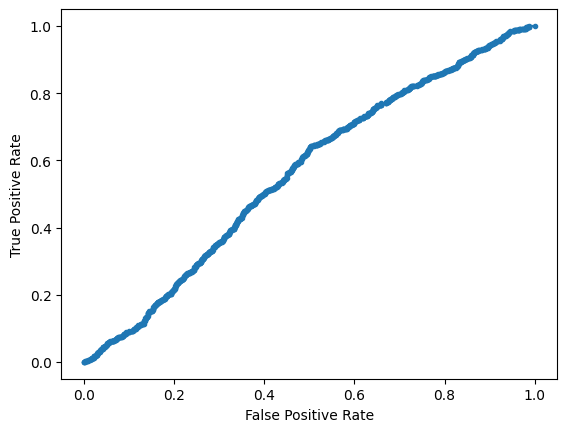

Accuracy: 59.21% Precision: 76.71% Recall: 62.61%
F1: 68.95% MCC: 0.1175
AUPRC: 74.26% AUROC: 56.13%
 accuracy [59.20661157024794]
 precision [76.70772676371782]
 recall [62.614259597806225]
 F1 [68.94816305988928]
 MCC [0.11747225928451835]
 AUPRC [74.26426767161833]
 AUROC [56.129174229368836]
2023-03-29 23:32:23.876206

Training # 2 5
2023-03-29 23:32:23.877931
2023-03-29 23:32:23.878021
Discriminator ZERO -1
Train 1:0 9582:4058 70.25%
Computed class weights: {0: 1.6806308526367668, 1: 0.7117512001669798}
Valid 1:0 2453:864 73.95%
FIT
2023-03-29 23:32:24.004202


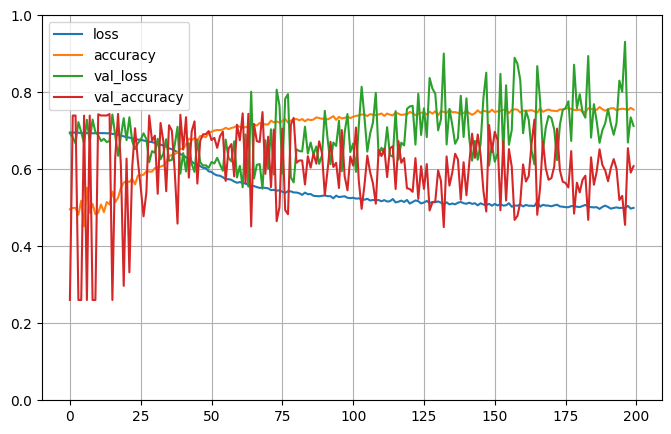


2023-03-29 23:36:07.415826

Testing # 2 5
2023-03-29 23:36:07.415931
2023-03-29 23:36:07.415990
PREDICT
2023-03-29 23:36:07.437155
Test 1:0 2453:864 73.95%
Predict 1:0 2011:1306 60.63%
Test sizes (3317, 1025) (3317,)
Range of scores: 0.0015874745 to 0.99984705
Score threshold 0.5
Confusion matrix
 [[ 435  429]
 [ 871 1582]]
Normalized matrix
 [[0.1311426  0.12933374]
 [0.26258667 0.47693699]]


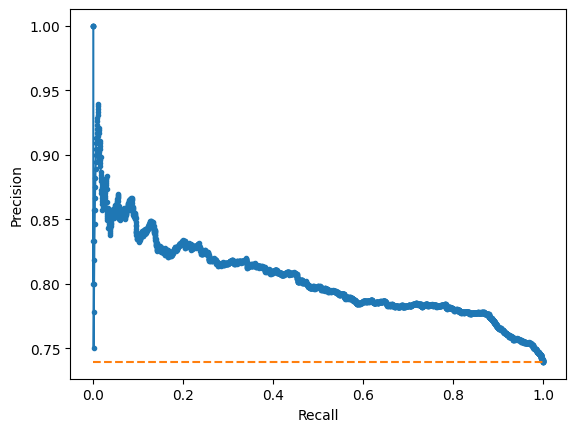

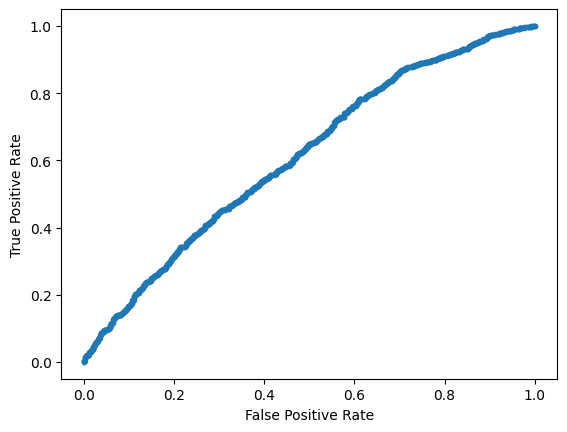

Accuracy: 60.81% Precision: 78.67% Recall: 64.49%
F1: 70.88% MCC: 0.1333
AUPRC: 80.30% AUROC: 61.18%
 accuracy [60.80795899909557]
 precision [78.66732968672302]
 recall [64.49245821443131]
 F1 [70.87813620071685]
 MCC [0.13330688194014378]
 AUPRC [80.29631930112164]
 AUROC [61.17648363304193]
2023-03-29 23:36:08.215163


In [23]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [24]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 55.59% std 4.64
 precision mean 75.38% std 2.50
 recall mean 55.84% std 10.49
 F1 mean 63.53% std 7.72
 MCC mean 0.10% std 0.03
 AUPRC mean 75.20% std 2.32
 AUROC mean 57.47% std 2.23
 accuracy [[58.84520884520884], [56.22241835834069], [49.86737400530504], [45.856524427953], [56.4659427443238], [58.59495625321668], [53.559322033898304], [56.45809414466131], [59.20661157024794], [60.80795899909557]]
 precision [[74.88419969119917], [75.72463768115942], [74.98069498069498], [77.52688172043011], [76.82186234817814], [73.21428571428571], [75.55958862673926], [69.73293768545994], [76.70772676371782], [78.66732968672302]]
 recall [[63.06892067620286], [58.94439967767929], [44.97452524316813], [31.86036235086169], [53.75354107648725], [64.64979831316465], [53.103741496598644], [60.90712742980562], [62.614259597806225], [64.49245821443131]]
 F1 [[68.4705882352941], [66.28908019936567], [56.22466705269253], [45.16129032258065], [63.25000000000001], [68.66601752677703], [62.37203